In this notebook, implemented and compared  2_Policy-Gradient algorithms on the Cartpole environment


# Part 1: The environment Cartpole

## Create and understand [Cartpole environment]((https://gymnasium.farama.org/environments/classic_control/cart_pole/)
---

💡 As usual, A good habit when you start to use an environment is to check its documentation

👉 https://gymnasium.farama.org/environments/classic_control/cart_pole/

---
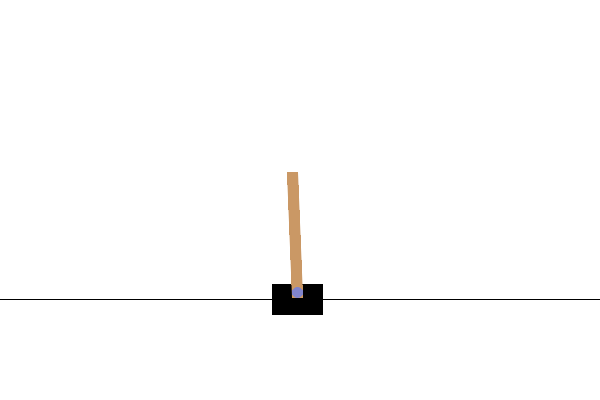

**The pendulum is placed upright on the cart and the goal of the PG agent is to balance the pole by applying forces in the left and right direction on the cart.**.

The action space (the set of possible actions the agent can take) is discrete with 2 actions available 🎮:
- 0:  Push cart to the left
- 1: Push cart to the right

The observation space corresponds to:
- 0: Cart Position
- 1: Cart Velocity
- 2: Pole Angle
- 3: Pole Angular Velocity


Reward function 💰:
- Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 500 for v1 and 200 for v0.

Episode End:

-The episode ends if any one of the following occurs:

- Termination: Pole Angle is greater than ±12°

- Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

- Truncation: Episode length is greater than 500 (200 for v0)

In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.2 MB/s eta 0:00:00


In [2]:
# import packages
import gymnasium as gym
import numpy as np

from collections import deque

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
env_id = "CartPole-v1"
env = gym.make(env_id)
s_size = env.observation_space.shape[0]
a_size = env.action_space.n
print(a_size)

2


In [4]:
# check the observation space
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Sample observation [-4.2970409e+00 -1.3758586e+38 -1.3492018e-01  1.1086552e+38]


In [5]:
#  Now check the action space
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample())


 _____ACTION SPACE_____ 

Action Space Shape 2
Action Space Sample 0


# Part 2: Design a REINFORCE-based agent

## Check if we have a GPU

- Let's check if we have a GPU
- If it's the case you should see `device:cuda0`

In [6]:
device = torch.device("cpu")
print(device)

cpu


First, let's create a policy network:

It is a neural network with two fully connected layers (fc1 and fc2). The fully connceted layer fc1 has a relu activation function. The output layer uses a softmax activation function

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class Policy(nn.Module):
    def __init__(self, s_size, a_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).to(device)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)


In [8]:
# debug policy to check if create properly
state,_ = env.reset()
debug_policy = Policy(s_size, a_size).to(device)
debug_policy.act(state)

(1, tensor([-0.7146], grad_fn=<SqueezeBackward1>))

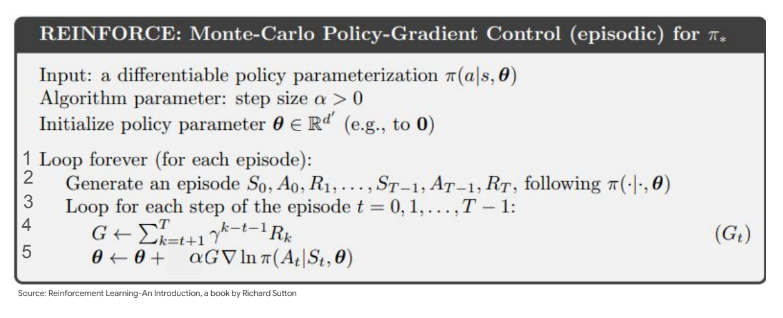

In [9]:
#hyperparameters
n_training_episodes = 1200
n_evaluation_episodes = 10
max_t = 1000
gamma = 1.0
lr = 1e-3
state_space = s_size
action_space = a_size
print_every = 100

In [10]:
# create an instance of cartpole_policy
policy = Policy(s_size, a_size)
# create an Adam optimizer for the cartpole with the learning rate defined in the hyperparameters
optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

In [11]:
scores_deque = deque(maxlen=100)
reinforce_rewards_train=[]
reinforce_losses=[]
# Line 1 of pseudocode
for i_episode in range(1, n_training_episodes + 1):
    saved_log_probs = []
    rewards = []
    state, _ = env.reset()
    for t in range(max_t):
        # TODO: get an action from the policy
        action, log_prob = policy.act(state)

        #  TODO: store the log probability in saved_log_probs
        saved_log_probs.append(log_prob)

        #  TODO: apply action to environment
        new_state, reward, done,truncated,info= env.step(action)

        # store the obtained reward in rewards
        rewards.append(reward)
        state = new_state

        if done or truncated:
            break

    scores_deque.append(sum(rewards))

    # Line 4 of pseudocode: calculate the return
    G = 0
    returns = deque(maxlen=max_t)
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)

    returns.reverse()
    returns = torch.tensor(returns)

    # Line 5: perform gradient descent(just add minus sign for policy loss)
    policy_losses = []
    for log_prob, disc_return in zip(saved_log_probs, returns):
        # TODO: compute policy loss
        policy_losses.append(-log_prob * disc_return)

    policy_loss = torch.stack(policy_losses).sum()
    reinforce_losses.append(policy_loss)

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    if i_episode % print_every == 0:
        print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    reinforce_rewards_train.append(np.mean(scores_deque))


Episode 100	Average Score: 21.24
Episode 200	Average Score: 20.56
Episode 300	Average Score: 23.21
Episode 400	Average Score: 24.01
Episode 500	Average Score: 23.85
Episode 600	Average Score: 29.65
Episode 700	Average Score: 33.63
Episode 800	Average Score: 36.49
Episode 900	Average Score: 45.70
Episode 1000	Average Score: 60.04
Episode 1100	Average Score: 178.09
Episode 1200	Average Score: 291.94


## Finally Define evaluation method 📝
- Here we define the evaluation method that we're going to use to test our trained Reinforce agent.

In [12]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state, _ = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, done, truncated, info = env.step(action)
      total_rewards_ep += reward

      if done or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)

  return  episode_rewards

In [13]:
episode_rewards=evaluate_agent(env,
               max_t,
               n_evaluation_episodes,
               policy)
mean_reward=np.mean(episode_rewards)
std_reward= np.std(episode_rewards)
print(mean_reward)
print(std_reward)

283.2
154.0550550939501


# Part 3: Design REINFORCE with baseline algorithm

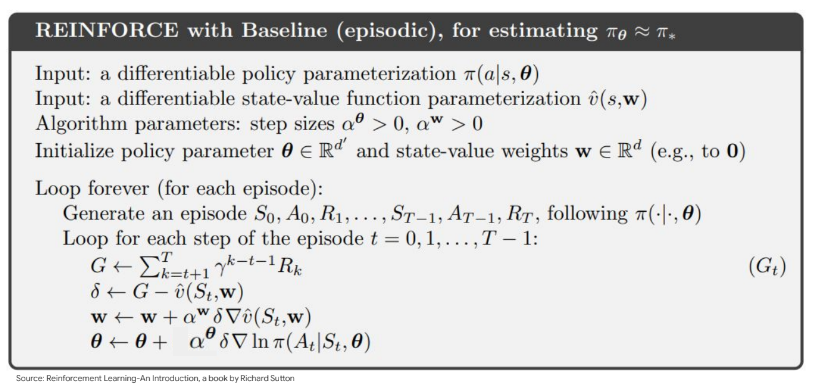

In [14]:
s_size,a_size

(4, 2)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class Policy_baseline(nn.Module):
    def __init__(self, s_size, a_size):
        super(Policy_baseline, self).__init__()
        self.fc1 = nn.Linear(s_size,64 )
        self.fc2 = nn.Linear(64, 10)
        self.fc3 = nn.Linear(10, 5)
        self.fc4 = nn.Linear(5, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).to(device)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [16]:
state,_ = env.reset()

In [17]:
# create an instance of cartpole_policy
policy_baseline = Policy_baseline(s_size, a_size)
# create an Adam optimizer for the cartpole with the learning rate defined in the hyperparameters
optimizer = torch.optim.Adam(policy_baseline.parameters(), lr=1e-3)

In [18]:
# Define a function to compute the moving average baseline
def compute_moving_average_baseline(returns, window_size=10):
    # Compute the moving average of returns using a window size
    baseline = sum(returns[-window_size:]) / window_size
    return baseline

In [19]:
reinforce_losses_baseline=[]
reinforce_rewards_baseline=[]
# Set the window size for the moving average baseline
window_size = 10

# Line 1 of pseudocode
for i_episode in range(1, n_training_episodes + 1):
    scores_deque = deque(maxlen=500)
    saved_log_probs = []
    rewards = []
    state, _ = env.reset()
    for t in range(max_t):
        # TODO: get an action from the policy
        action, log_prob = policy_baseline.act(state)

        #  TODO: store the log probability in saved_log_probs
        saved_log_probs.append(log_prob)

        #  TODO: apply action to environment
        new_state, reward, done, truncated, info = env.step(action)

        # store the obtained reward in rewards
        rewards.append(reward)
        state = new_state
        if done or truncated:  # truncated length of episodes is greater than 200 for v0
            break


    scores_deque.append(sum(rewards))

    # Line 4 of pseudocode: calculate the return
    G = 0
    returns = deque(maxlen=max_t)
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)

    returns.reverse()
    returns = torch.tensor(returns)

    # Calculate the moving average baseline
    baseline = compute_moving_average_baseline(returns, window_size)

    # Subtract the baseline from the returns
    returns -= baseline

    # Line 5: perform gradient descent(just add minus sign for policy loss)
    policy_losses = []
    for log_prob, disc_return in zip(saved_log_probs, returns):
        # Compute policy loss using the adjusted returns
        policy_losses.append(-log_prob * disc_return)

    policy_loss = torch.stack(policy_losses).sum()
    reinforce_losses_baseline.append(policy_loss)

    # Update the weights
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    if i_episode % print_every == 0:
        print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    reinforce_rewards_baseline.append(np.mean(scores_deque))

Episode 100	Average Score: 43.00
Episode 200	Average Score: 55.00
Episode 300	Average Score: 500.00
Episode 400	Average Score: 480.00
Episode 500	Average Score: 18.00
Episode 600	Average Score: 264.00
Episode 700	Average Score: 500.00
Episode 800	Average Score: 500.00
Episode 900	Average Score: 500.00
Episode 1000	Average Score: 324.00
Episode 1100	Average Score: 500.00
Episode 1200	Average Score: 500.00


In [20]:
episode_rewards=evaluate_agent(env,
               max_t,
               n_evaluation_episodes,
               policy_baseline)
mean_reward=np.mean(episode_rewards)
std_reward= np.std(episode_rewards)
print(mean_reward)
print(std_reward)

500.0
0.0


# Part 4: Compare the REINFORCE (part 2) and REINFORCE with baseline (part 3)

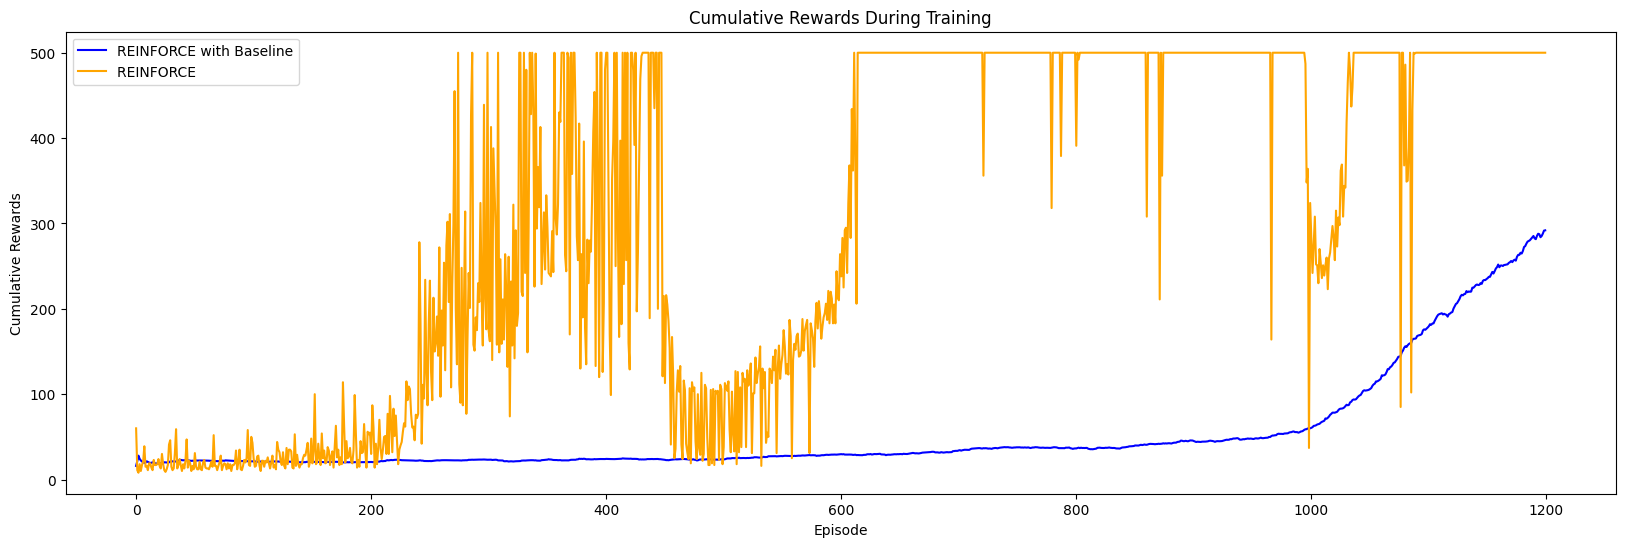

In [21]:
import matplotlib.pyplot as plt

# Plotting cumulative rewards during training
plt.figure(figsize=(20, 6))
plt.plot(reinforce_rewards_train, label='REINFORCE with Baseline', color='blue')
plt.plot(reinforce_rewards_baseline, label='REINFORCE ', color='orange')
plt.title('Cumulative Rewards During Training')
plt.xlabel('Episode')
plt.ylabel('Cumulative Rewards')
plt.legend()
plt.show()

so here we can notice that during training the rewards are higher and more stable for the REINFORCE with baseline.so, we can conclude that incorporating a baseline has improved learning.

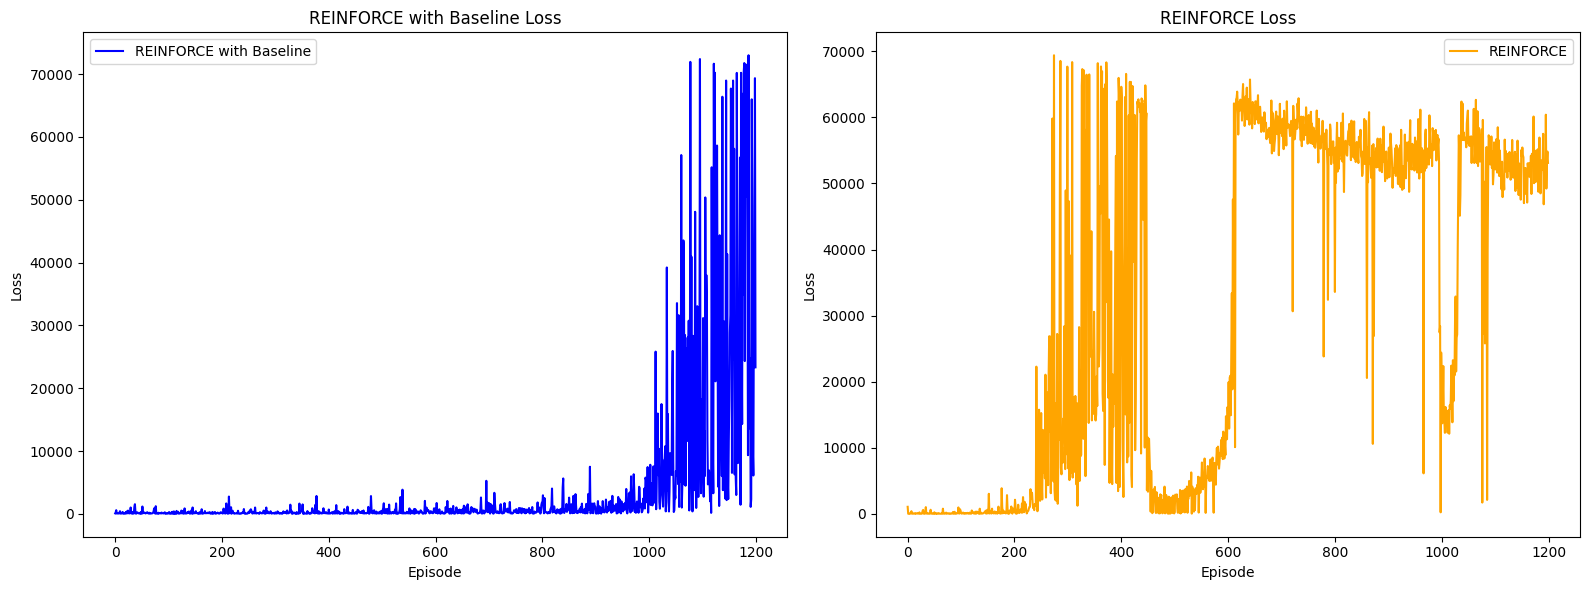

In [22]:
# Plotting the loss function behavior side by side
plt.figure(figsize=(16, 6))

# Subplot for REINFORCE
plt.subplot(1, 2, 1)
plt.plot([loss.item() for loss in reinforce_losses], label='REINFORCE with Baseline', color='blue')
plt.title('REINFORCE with Baseline Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()

# Subplot for REINFORCE with Baseline
plt.subplot(1, 2, 2)
plt.plot([loss.item() for loss in reinforce_losses_baseline], label='REINFORCE', color='orange')
plt.title('REINFORCE Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


The loss function behavior provide insights into how well the algorithm is converging.so here the loss function in the baseline is lower than without baseline. A smoother convergence might indicate the effectiveness of a baseline.